#### Jérémy TREMBLAY

# Project 2: The Simpsons Faces

In [2]:
# Import used in this notebook.
import os
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, color, exposure, transform
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization

Fix seeds for reprodutiblity principles.

In [3]:
np.random.seed(42)
random.seed(42)

In the subfolder of this path, there is a dataset extracted from The Simpsons serie.
The mission is to classify correctly each person for each image to the corresponding personnage. This dataset is composed of more than 6000 images for training and nearly 600 for testing. Each image is associated with a class. The dataset offers 18 different classes, i.e. 18 different characters from The Simpsons.

Constraints:
* Don't cheat!
* Respect a model with at most 1M parameters (it will be checked)
* Max dataset image size must be (64, 64)

**The goal of this notebook is to realize the best possible model to predict data.**

## First step : load data

The first step is to load the two CSV that will be used in this notebook with `pandas`.

In [4]:
# Specify the relative path of the the files.
train_file_path = 'datasets/train.csv'
test_file_path = 'datasets/test.csv'

# Load the database into a DataFrame.
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Display the first few rows of the DataFrame with head.
print(df_train.head())
print("---------------------------------------------------")
print(df_test.head())

   width  height          className  classId                path
0    236     333       bart_simpson        2  dataset_000000.png
1    154     223       nelson_muntz       15  dataset_000001.png
2    187     294      kent_brockman        8  dataset_000002.png
3    219     281       ned_flanders       14  dataset_000003.png
4    278     384  principal_skinner       16  dataset_000004.png
---------------------------------------------------
   width  height             path
0    194     328  test_000000.png
1    236     363  test_000001.png
2    185     373  test_000002.png
3    380     399  test_000003.png
4    152     294  test_000004.png


Perfect. We will now explore data.

In [4]:
print(df_train.isnull().any())
print(df_test.isnull().any())

width        False
height       False
className    False
classId      False
path         False
dtype: bool
width     False
height    False
path      False
dtype: bool


The datasets are already clean, we can easily read it now and search some information.

In [5]:
# Know the dimensions of the dataframes.
print(df_train.shape)
print(df_test.shape)

(5458, 5)
(596, 3)


There is 5458 rows and 5 columns for the train dataset and 596 rows and 3 columns for the test dataset, let's check the content more in detail with some stats.

In [6]:
# Display usefull information about the train dataset.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5458 entries, 0 to 5457
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   width      5458 non-null   int64 
 1   height     5458 non-null   int64 
 2   className  5458 non-null   object
 3   classId    5458 non-null   int64 
 4   path       5458 non-null   object
dtypes: int64(3), object(2)
memory usage: 213.3+ KB


In [7]:
# Display usefull information about the test dataset.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   596 non-null    int64 
 1   height  596 non-null    int64 
 2   path    596 non-null    object
dtypes: int64(2), object(1)
memory usage: 14.1+ KB


In [8]:
df_train.describe()

,width,height,classId
count,5458.000000,5458.000000,5458.000000
mean,226.390253,312.764749,8.030781
std,73.223297,82.585173,5.278480
min,111.000000,114.000000,0.000000
25%,173.000000,252.000000,3.000000
50%,214.000000,317.000000,8.000000
75%,264.000000,373.000000,13.000000
max,629.000000,618.000000,17.000000


In [9]:
df_test.describe()

,width,height
count,596.000000,596.00000
mean,228.652685,315.07047
std,79.461392,85.25644
min,112.000000,130.00000
25%,173.750000,253.00000
50%,210.000000,319.00000
75%,269.250000,380.00000
max,800.000000,816.00000


Since we want to predict the class of the simpson, we will use the columns `path` which contains the path to the image of the simpson. The dataset also provides the width and length of the images and the `className` containing the name of the personnage and its associated `classId`. For the test dataset, we also have the size of the image and their paths, but not their classes because it is what we want to know.
Let's check the number of simpsonfor each class in the train dataset to see if the data is well balanced between the classes.

In [10]:
df_train.className.value_counts()

className
homer_simpson               533
abraham_grampa_simpson      512
marge_simpson               491
bart_simpson                485
ned_flanders                483
charles_montgomery_burns    461
lisa_simpson                420
principal_skinner           407
nelson_muntz                186
krusty_the_clown            186
chief_wiggum                181
kent_brockman               168
apu_nahasapeemapetilon      166
edna_krabappel              164
moe_szyslak                 164
milhouse_van_houten         164
comic_book_guy              149
sideshow_bob                138
Name: count, dtype: int64

We can see that the data is not balanced between the classes. For example, there is more often marge simpson than kent brockman. We will use a tool later to balance the data and improve the training of our model, this is an important step.   

We also need to do a dictionnary to link a `classId` to it's `className` to display some data, it can be usefull but just for us because our model will only use the `classId` to separate the images. Let's do it.

In [11]:
# Create a dictionnary to associate a classId to a className.
class_dict = dict(zip(df_train['classId'], df_train['className']))

# Display data.
print(class_dict)

{2: 'bart_simpson', 15: 'nelson_muntz', 8: 'kent_brockman', 14: 'ned_flanders', 16: 'principal_skinner', 0: 'abraham_grampa_simpson', 11: 'marge_simpson', 3: 'charles_montgomery_burns', 5: 'comic_book_guy', 7: 'homer_simpson', 6: 'edna_krabappel', 4: 'chief_wiggum', 10: 'lisa_simpson', 9: 'krusty_the_clown', 13: 'moe_szyslak', 1: 'apu_nahasapeemapetilon', 12: 'milhouse_van_houten', 17: 'sideshow_bob'}


We are now ready to work with the data to separate it.

## Second step : separate data

We must use our train dataset and split it to use it to train and test our model and check his performances. The test dataset cannot be used for that because it contains the data we want to predict, and we cannot check the effiency of the mdoel with it. We do not need to clean the dataset as saw at the previous step and we will not used the `width` and `heigh` columns of the datasets because they are not usefull. The `className` is usefull just for us, as human, to read the name of the simpson, but the model will use the integer value of the `classId` column to classify the data. We want to separate our data : 80% for train and 20% for test.

In [12]:
# Separate the dataset in two sets.
data = df_train.sample(frac=1., axis=0, random_state=42)
data_train = data.sample(frac=0.8, axis=0, random_state=42) # 80 / 20
data_test = data.drop(data_train.index)

Now our data is separated, we need to process it. In fact, we have here images of different sizes as seen previously, so we need to resize all of them at the same size and also apply a treatment on them. Then it will be possible to use our data to train our model.

## Thrid step: process and normalize data 

We must resize all the images at the same size. At the first step, we have seen that all the images are larger than 100x100 so we can resize them to a 64x64 format.  
We can also preprocess images by applying them an effect, for example, we can apply a gray scale or transform them into RGB images before normalizing them. This step will for sure modify the performance of our model, so we need to do a function if we want to test various solutions.

In [13]:
def preprocessing_and_normalizing(dataframe, folder='train', transformation=0):
    out_x_train = []
    img_size = (64, 64)
    folder = 'datasets/simpsons/' + folder

    # Iterate through each image of our dataset.
    for i, row in dataframe.iterrows():
        # Read image content.
        img_path = os.path.join(folder, row['path'])
        img_arr = io.imread(img_path)

        # Resize image to new shape.
        img_arr = transform.resize(img_arr, img_size, preserve_range=True)

        # Here come the transformation part. Depending on the tranformation parameter given to the function, something will be apply to the images.
        if transformation == 1: # Gray scale.
            img_arr = color.rgb2gray(img_arr).reshape(img_size[0], img_size[1], 1)
        elif transformation == 2: # Better exposure.
            img_arr = exposure.rescale_intensity(img_arr)
        elif transformation == 3: # Better exposure + gray scale.
            img_arr = exposure.rescale_intensity(img_arr)
            img_arr = color.rgb2gray(img_arr).reshape(img_size[0], img_size[1], 1)

        # Normalize image and add it to the list.
        img_arr = img_arr / 255.

        out_x_train.append(img_arr)
    
    # Return new normalized data.
    return out_x_train

Later in this challenge, I wanted to test other combinations with gray scale or RGB, so I decided to add this transformation parameter in this function and the associated treatments.  

Now the data is ready, there is a last thing to do before using it: we mut save it to avoid to reload and process again all the data each time we want to test our models.

## Fourth step: Create a dataset file

Let's now use our function to save our data in a h5 file to easily load it again. We first create two functions to load and save.

In [6]:
# Define constants and create folder if not existing.
output_folder = 'working/datasets'
os.makedirs(output_folder, exist_ok=True)

def save_dataset(out_x_train, out_x_test, filename):
    # Open & create the file and image save data inside to reuse it.
    with h5py.File(os.path.join(output_folder, filename), "w") as f:
        f.create_dataset("x_train", data=out_x_train)
        f.create_dataset("y_train", data=data_train.classId.to_numpy())

        # Do the same for test data. 
        f.create_dataset("x_test", data=out_x_test)
        f.create_dataset("y_test", data=data_test.classId.to_numpy())

def read_dataset(filename):
    # Read dataset h5 file.
    with h5py.File(os.path.join(output_folder, filename), 'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]

        # Do the same for test data.
        x_test = f['x_test'][:]
        y_test = f['y_test'][:]

    return x_train, y_train, x_test, y_test

Now let use our functions to load our images from dataframe, process them, save them into different h5 files: one with no processing, one with a gray scale and the other with RGB. This will be usefull later.

In [15]:
# With no processing. We normalize our two dataframe : train and test and then save them into the file.
out_x_train = preprocessing_and_normalizing(data_train)
out_x_test = preprocessing_and_normalizing(data_test)
save_dataset(out_x_train, out_x_test, "dataset_standard.h5")

# With gray scale.
out_x_train = preprocessing_and_normalizing(data_train, transformation=1)
out_x_test = preprocessing_and_normalizing(data_test, transformation=1)
save_dataset(out_x_train, out_x_test, "dataset_gray.h5")

# With RGB (better exposure).
out_x_train = preprocessing_and_normalizing(data_train, transformation=2)
out_x_test = preprocessing_and_normalizing(data_test, transformation=2)
save_dataset(out_x_train, out_x_test, "dataset_exposure.h5")

# With better exposure + gray scale.
out_x_train = preprocessing_and_normalizing(data_train, transformation=3)
out_x_test = preprocessing_and_normalizing(data_test, transformation=3)
save_dataset(out_x_train, out_x_test, "dataset_exposure_gray.h5")

Let processing the test data now (the thing we want to predict) and save it.

In [20]:
# With no processing.
out_x_final = preprocessing_and_normalizing(df_test, folder='test')
dataset_file_final = os.path.join(output_folder, 'dataset_standard_final.h5')
with h5py.File(dataset_file_final, "w") as f:
    f.create_dataset("x_test",  data=out_x_final)

# With gray scale.
out_x_final = preprocessing_and_normalizing(df_test, folder='test', transformation=1)
dataset_file_final = os.path.join(output_folder, 'dataset_gray_final.h5')
with h5py.File(dataset_file_final, "w") as f:
    f.create_dataset("x_test",  data=out_x_final)

# With RGB (better exposure).
out_x_final = preprocessing_and_normalizing(df_test, folder='test', transformation=2)
dataset_file_final = os.path.join(output_folder, 'dataset_exposure_final.h5')
with h5py.File(dataset_file_final, "w") as f:
    f.create_dataset("x_test",  data=out_x_final)

# With better exposure + gray scale.
out_x_final = preprocessing_and_normalizing(df_test, folder='test', transformation=3)
dataset_file_final = os.path.join(output_folder, 'dataset_exposure_gray_final.h5')
with h5py.File(dataset_file_final, "w") as f:
    f.create_dataset("x_test",  data=out_x_final)

Now we have our data we are ready to create a model, train it and see results.

## Fifth step: read data

Now we have our data saved, let's read it to yuse it.

In [7]:
x_train_standard, y_train_standard, x_test_standard, y_test_standard = read_dataset("dataset_standard.h5")
x_train_gray, y_train_gray, x_test_gray, y_test_gray = read_dataset("dataset_gray.h5")
x_train_exposure, y_train_exposure, x_test_exposure, y_test_exposure = read_dataset("dataset_exposure.h5")
x_train_exposure_gray, y_train_exposure_gray, x_test_exposure_gray, y_test_exposure_gray = read_dataset("dataset_exposure_gray.h5")

Do the same for our final predictions.

In [8]:
with h5py.File(os.path.join(output_folder, 'dataset_standard_final.h5'), 'r') as f:
    x_final_standard = f['x_test'][:]
with h5py.File(os.path.join(output_folder, 'dataset_gray_final.h5'), 'r') as f:
    x_final_gray = f['x_test'][:]
with h5py.File(os.path.join(output_folder, 'dataset_exposure_final.h5'), 'r') as f:
    x_final_exposure = f['x_test'][:]
with h5py.File(os.path.join(output_folder, 'dataset_exposure_gray_final.h5'), 'r') as f:
    x_final_exposure_gray = f['x_test'][:]

Let's check the sizes to be sure everything is ok.

In [9]:
print(x_train_exposure.shape)
print(x_train_standard.shape)
print(x_train_gray.shape)
print(x_train_exposure_gray.shape)
print(x_test_exposure.shape)
print(x_test_standard.shape)
print(x_test_gray.shape)
print(x_test_exposure_gray.shape)

print(y_train_standard.shape)
print(y_train_gray.shape)
print(y_train_exposure.shape)
print(y_train_exposure_gray.shape)
print(y_test_exposure.shape)
print(y_test_standard.shape)
print(y_test_gray.shape)
print(y_test_exposure_gray.shape)

print(x_final_exposure.shape)
print(x_final_standard.shape)
print(x_final_gray.shape)
print(x_final_exposure_gray.shape)

(4366, 64, 64, 3)
(4366, 64, 64, 3)
(4366, 64, 64, 1)
(4366, 64, 64, 1)
(1092, 64, 64, 3)
(1092, 64, 64, 3)
(1092, 64, 64, 1)
(1092, 64, 64, 1)
(4366,)
(4366,)
(4366,)
(4366,)
(1092,)
(1092,)
(1092,)
(1092,)
(596, 64, 64, 3)
(596, 64, 64, 3)
(596, 64, 64, 1)
(596, 64, 64, 1)


It's seems ok. We note that we have a 3 sized images for the standard and exposure images only, this is beecause they are RGB images, the others are a gray scale. We will try our models on all these types of images to see which one is the best.

## Sixth step: Create and train a CNN

We are now in the core subject of this project. Our model will be a CNN. We will do NOT use a DNN because we know that the CNN can make better performances than DNN (in overall), so we will directly skip to a CNN. But first, we need to define a `get_model` function to create such a model. But how can we create our model ? This is simple.  

* It will be composed of an Input layer which will take the geometry of the input data as a parameter, here 64* 64 * 1 (in our case we will work with images in grayscale, therefore 1 color).
* Inputs will be passed to 2 `Conv2D` layers each with a kernel of 3 * 3, a *stride* of 1 and no *padding*. These layers will respectively return a number of 8 and 16 feature maps (*features maps*). The activation functions will be `ReLu`.
* A `Flatten` layer which allows the flattening of data into a vector in order to be able to correctly connect our following layers.
* Then, two `Dense` layers, both composed of `ReLu` type activation functions and respectively 128 and 32 neurons.
* A `Dropout` layer after each hidden layer.
* Finally, a final layer of type `Dense` with a number of neurons corresponding to the number of classes to predict (18 different characters). This will be the output layer.

In [10]:
def get_model_cnn_v1(input_shape=(64, 64, 1), dropout_rate=0.2):
    """
    Creates a Sequential model for classifying the simpsons using a pooling system.

    Parameters:
    - input_shape (tuple): The shape of input images (default is (64, 64, 1)).
    - dropout_rate (float): The droupout rate used in Droupout (default is 0.2).

    Returns:
    - model (Sequential): The compiled Keras Sequential model.
    """
    model = Sequential()

    # Convolutional layers.
    model.add(Input(shape=input_shape))
    if len(input_shape) == 3:
        model.add(Conv2D(8, kernel_size=(3, 3), strides=1, padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(16, kernel_size=(3, 3), strides=1, padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer.
    model.add(Flatten())

    # Dense layers with Dropout.
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Output layer.
    num_classes = 18  # Number of classes (18 simpsons).
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [11]:
# Log directory for TensorBoard.
log_dir = 'logs/cnn_v1'
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Now let's see the number of parameters to be sure there are not more than 1M.

In [12]:
model_cnn_1_standard = get_model_cnn_v1(input_shape=(64, 64, 3)) # Because we use a RGB image we precise the 3 here.
model_cnn_1_standard.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)              

It's good, but the first time I do this, there was over than 7M parameters... To reduce this number I have decided to change my model and add it some pooling to reduce the number of parameters to 400K. Let's train it now. First we will use it on stadard data then try it on the gray scale images, the exposure and the exposure + gray scale images.

In [13]:
# Define usefull callbacks.
save_callback_1 = keras.callbacks.ModelCheckpoint(filepath="models/model_v1", verbose=0, save_best_only=True)
tensorboard_callback_1 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v1_standard", histogram_freq=1)

# Create folders.
os.makedirs('models/', exist_ok=True)
os.makedirs('logs/', exist_ok=True)

In [14]:
samples_weight = compute_sample_weight("balanced", y_train_standard) # Used to manage inbalanced data.

model_cnn_1_standard.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on 50 epochs.
history_v1_standard = model_cnn_1_standard.fit(
    x=x_train_standard,
    y=y_train_standard,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_1, tensorboard_callback_1],
    validation_data=(x_test_standard, y_test_standard),
    sample_weight=samples_weight
)


Epoch 1/50


9/9 [==============================] - ETA: 0s - loss: 2.8627 - accuracy: 0.0822INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 15s 2s/step - loss: 2.8627 - accuracy: 0.0822 - val_loss: 2.7496 - val_accuracy: 0.1639
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.6833 - accuracy: 0.1640INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 8s 960ms/step - loss: 2.6833 - accuracy: 0.1640 - val_loss: 2.4797 - val_accuracy: 0.2390
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.4751 - accuracy: 0.2112INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 659ms/step - loss: 2.4751 - accuracy: 0.2112 - val_loss: 2.2466 - val_accuracy: 0.3352
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 2.2749 - accuracy: 0.2776INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 8s 932ms/step - loss: 2.2749 - accuracy: 0.2776 - val_loss: 2.0397 - val_accuracy: 0.4451
Epoch 5/50
9/9 [==============================] - ETA: 0s - loss: 2.0996 - accuracy: 0.3326INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 8s 1s/step - loss: 2.0996 - accuracy: 0.3326 - val_loss: 1.8846 - val_accuracy: 0.5018
Epoch 6/50
9/9 [==============================] - ETA: 0s - loss: 1.9543 - accuracy: 0.3944INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 600ms/step - loss: 1.9543 - accuracy: 0.3944 - val_loss: 1.7244 - val_accuracy: 0.5174
Epoch 7/50
9/9 [==============================] - ETA: 0s - loss: 1.8068 - accuracy: 0.4201INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 3s 355ms/step - loss: 1.8068 - accuracy: 0.4201 - val_loss: 1.5861 - val_accuracy: 0.5870
Epoch 8/50
9/9 [==============================] - ETA: 0s - loss: 1.6795 - accuracy: 0.4698INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 9s 1s/step - loss: 1.6795 - accuracy: 0.4698 - val_loss: 1.4672 - val_accuracy: 0.6035
Epoch 9/50
9/9 [==============================] - ETA: 0s - loss: 1.5804 - accuracy: 0.5021INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 485ms/step - loss: 1.5804 - accuracy: 0.5021 - val_loss: 1.3681 - val_accuracy: 0.6484
Epoch 10/50
9/9 [==============================] - ETA: 0s - loss: 1.4418 - accuracy: 0.5529INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 622ms/step - loss: 1.4418 - accuracy: 0.5529 - val_loss: 1.2575 - val_accuracy: 0.6630
Epoch 11/50
9/9 [==============================] - ETA: 0s - loss: 1.3368 - accuracy: 0.5731INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 447ms/step - loss: 1.3368 - accuracy: 0.5731 - val_loss: 1.2056 - val_accuracy: 0.6758
Epoch 12/50
9/9 [==============================] - ETA: 0s - loss: 1.2627 - accuracy: 0.5902INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 466ms/step - loss: 1.2627 - accuracy: 0.5902 - val_loss: 1.1002 - val_accuracy: 0.6987
Epoch 13/50
9/9 [==============================] - ETA: 0s - loss: 1.1918 - accuracy: 0.6257INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 546ms/step - loss: 1.1918 - accuracy: 0.6257 - val_loss: 1.0339 - val_accuracy: 0.7143
Epoch 14/50
9/9 [==============================] - ETA: 0s - loss: 1.1442 - accuracy: 0.6276INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 452ms/step - loss: 1.1442 - accuracy: 0.6276 - val_loss: 1.0041 - val_accuracy: 0.7143
Epoch 15/50
9/9 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.6535INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 522ms/step - loss: 1.0741 - accuracy: 0.6535 - val_loss: 0.9773 - val_accuracy: 0.7225
Epoch 16/50
9/9 [==============================] - 2s 234ms/step - loss: 1.0283 - accuracy: 0.6718 - val_loss: 0.9873 - val_accuracy: 0.7161
Epoch 17/50
9/9 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.6896INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 425ms/step - loss: 0.9814 - accuracy: 0.6896 - val_loss: 0.9270 - val_accuracy: 0.7408
Epoch 18/50
9/9 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.6965INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 559ms/step - loss: 0.9215 - accuracy: 0.6965 - val_loss: 0.8843 - val_accuracy: 0.7335
Epoch 19/50
9/9 [==============================] - ETA: 0s - loss: 0.8784 - accuracy: 0.7107INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 3s 390ms/step - loss: 0.8784 - accuracy: 0.7107 - val_loss: 0.8778 - val_accuracy: 0.7518
Epoch 20/50
9/9 [==============================] - ETA: 0s - loss: 0.8501 - accuracy: 0.7114INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 496ms/step - loss: 0.8501 - accuracy: 0.7114 - val_loss: 0.8614 - val_accuracy: 0.7546
Epoch 21/50
9/9 [==============================] - 2s 280ms/step - loss: 0.8085 - accuracy: 0.7348 - val_loss: 0.8798 - val_accuracy: 0.7527
Epoch 22/50
9/9 [==============================] - 2s 267ms/step - loss: 0.7819 - accuracy: 0.7387 - val_loss: 0.8777 - val_accuracy: 0.7473
Epoch 23/50
9/9 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.7451INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 3s 379ms/step - loss: 0.7555 - accuracy: 0.7451 - val_loss: 0.8246 - val_accuracy: 0.7665
Epoch 24/50
9/9 [==============================] - 2s 184ms/step - loss: 0.7411 - accuracy: 0.7556 - val_loss: 0.8337 - val_accuracy: 0.7647
Epoch 25/50
9/9 [==============================] - 2s 220ms/step - loss: 0.6927 - accuracy: 0.7568 - val_loss: 0.8421 - val_accuracy: 0.7582
Epoch 26/50
9/9 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7714INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 618ms/step - loss: 0.6670 - accuracy: 0.7714 - val_loss: 0.8065 - val_accuracy: 0.7756
Epoch 27/50
9/9 [==============================] - 4s 478ms/step - loss: 0.6449 - accuracy: 0.7751 - val_loss: 0.8076 - val_accuracy: 0.7573
Epoch 28/50
9/9 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.7833INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 474ms/step - loss: 0.6386 - accuracy: 0.7833 - val_loss: 0.7877 - val_accuracy: 0.7656
Epoch 29/50
9/9 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.7783INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 533ms/step - loss: 0.6076 - accuracy: 0.7783 - val_loss: 0.7803 - val_accuracy: 0.7738
Epoch 30/50
9/9 [==============================] - 2s 286ms/step - loss: 0.5891 - accuracy: 0.7891 - val_loss: 0.7909 - val_accuracy: 0.7647
Epoch 31/50
9/9 [==============================] - 3s 336ms/step - loss: 0.5721 - accuracy: 0.8000 - val_loss: 0.7922 - val_accuracy: 0.7747
Epoch 32/50
9/9 [==============================] - 3s 369ms/step - loss: 0.5472 - accuracy: 0.8122 - val_loss: 0.7942 - val_accuracy: 0.7738
Epoch 33/50
9/9 [==============================] - 4s 429ms/step - loss: 0.5167 - accuracy: 0.8142 - val_loss: 0.7867 - val_accuracy: 0.7766
Epoch 34/50
9/9 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.8216INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 584ms/step - loss: 0.4940 - accuracy: 0.8216 - val_loss: 0.7725 - val_accuracy: 0.7720
Epoch 35/50
9/9 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.8268INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 6s 674ms/step - loss: 0.4651 - accuracy: 0.8268 - val_loss: 0.7537 - val_accuracy: 0.7866
Epoch 36/50
9/9 [==============================] - 4s 487ms/step - loss: 0.4659 - accuracy: 0.8328 - val_loss: 0.7617 - val_accuracy: 0.7784
Epoch 37/50
9/9 [==============================] - 3s 361ms/step - loss: 0.4437 - accuracy: 0.8321 - val_loss: 0.7623 - val_accuracy: 0.7821
Epoch 38/50
9/9 [==============================] - 3s 317ms/step - loss: 0.4369 - accuracy: 0.8452 - val_loss: 0.7661 - val_accuracy: 0.7747
Epoch 39/50
9/9 [==============================] - 3s 365ms/step - loss: 0.4223 - accuracy: 0.8394 - val_loss: 0.7577 - val_accuracy: 0.7793
Epoch 40/50
9/9 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8426INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 6s 657ms/step - loss: 0.4287 - accuracy: 0.8426 - val_loss: 0.7433 - val_accuracy: 0.7885
Epoch 41/50
9/9 [==============================] - 3s 380ms/step - loss: 0.4033 - accuracy: 0.8511 - val_loss: 0.7479 - val_accuracy: 0.7857
Epoch 42/50
9/9 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8516INFO:tensorflow:Assets written to: models\model_v1\assets


INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 5s 637ms/step - loss: 0.3893 - accuracy: 0.8516 - val_loss: 0.7405 - val_accuracy: 0.7857
Epoch 43/50
9/9 [==============================] - 5s 567ms/step - loss: 0.3765 - accuracy: 0.8571 - val_loss: 0.7658 - val_accuracy: 0.7793
Epoch 44/50
9/9 [==============================] - 3s 343ms/step - loss: 0.3643 - accuracy: 0.8596 - val_loss: 0.7577 - val_accuracy: 0.7912
Epoch 45/50
9/9 [==============================] - 2s 220ms/step - loss: 0.3551 - accuracy: 0.8628 - val_loss: 0.7482 - val_accuracy: 0.7894
Epoch 46/50
9/9 [==============================] - 2s 232ms/step - loss: 0.3397 - accuracy: 0.8644 - val_loss: 0.7484 - val_accuracy: 0.7903
Epoch 47/50
9/9 [==============================] - 2s 235ms/step - loss: 0.3321 - accuracy: 0.8708 - val_loss: 0.7527 - val_accuracy: 0.7912
Epoch 48/50
9/9 [==============================] - 2s 236ms/step - loss: 0.3325 - accuracy: 0.8749 - val_loss: 0.7512 - val_accuracy: 0.7940
Epoch 49/50
9/9 [========

INFO:tensorflow:Assets written to: models\model_v1\assets


9/9 [==============================] - 4s 496ms/step - loss: 0.3048 - accuracy: 0.8800 - val_loss: 0.7320 - val_accuracy: 0.7985


Let's now renew the operation with each of the previous image types.

In [15]:
# Gray scale.
model_cnn_1_gray = get_model_cnn_v1(input_shape=(64, 64, 1))
tensorboard_callback_1 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v1_gray", histogram_freq=1)
samples_weight = compute_sample_weight("balanced", y_train_gray)
model_cnn_1_gray.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v1_gray = model_cnn_1_gray.fit(
    x=x_train_gray,
    y=y_train_gray,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_1, tensorboard_callback_1],
    validation_data=(x_test_gray, y_test_gray),
    sample_weight=samples_weight
)

Epoch 1/50
9/9 [==============================] - 11s 433ms/step - loss: 2.8986 - accuracy: 0.0648 - val_loss: 2.8682 - val_accuracy: 0.1282
Epoch 2/50
9/9 [==============================] - 2s 254ms/step - loss: 2.8645 - accuracy: 0.1088 - val_loss: 2.8129 - val_accuracy: 0.1511
Epoch 3/50
9/9 [==============================] - 3s 360ms/step - loss: 2.8119 - accuracy: 0.1230 - val_loss: 2.7258 - val_accuracy: 0.1886
Epoch 4/50
9/9 [==============================] - 3s 322ms/step - loss: 2.7343 - accuracy: 0.1475 - val_loss: 2.6300 - val_accuracy: 0.2060
Epoch 5/50
9/9 [==============================] - 5s 552ms/step - loss: 2.6416 - accuracy: 0.1606 - val_loss: 2.5157 - val_accuracy: 0.2802
Epoch 6/50
9/9 [==============================] - 2s 208ms/step - loss: 2.5414 - accuracy: 0.2055 - val_loss: 2.4311 - val_accuracy: 0.3159
Epoch 7/50
9/9 [==============================] - 2s 210ms/step - loss: 2.4658 - accuracy: 0.2364 - val_loss: 2.3143 - val_accuracy: 0.3342
Epoch 8/50
9/9 [===

In [16]:
# Exposure.
model_cnn_1_exposure = get_model_cnn_v1(input_shape=(64, 64, 3))
tensorboard_callback_1 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v1_exposure", histogram_freq=1)
samples_weight = compute_sample_weight("balanced", y_train_exposure)
model_cnn_1_exposure.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v1_exposure = model_cnn_1_exposure.fit(
    x=x_train_exposure,
    y=y_train_exposure,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_1, tensorboard_callback_1],
    validation_data=(x_test_exposure, y_test_exposure),
    sample_weight=samples_weight
)

Epoch 1/50
9/9 [==============================] - 46s 5s/step - loss: 2.8902 - accuracy: 0.0598 - val_loss: 2.8880 - val_accuracy: 0.1071
Epoch 2/50
9/9 [==============================] - 3s 307ms/step - loss: 2.8877 - accuracy: 0.0731 - val_loss: 2.8810 - val_accuracy: 0.1090
Epoch 3/50
9/9 [==============================] - 3s 368ms/step - loss: 2.8833 - accuracy: 0.0873 - val_loss: 2.8698 - val_accuracy: 0.1145
Epoch 4/50
9/9 [==============================] - 3s 325ms/step - loss: 2.8720 - accuracy: 0.1102 - val_loss: 2.8540 - val_accuracy: 0.1529
Epoch 5/50
9/9 [==============================] - 2s 254ms/step - loss: 2.8494 - accuracy: 0.1296 - val_loss: 2.7978 - val_accuracy: 0.1703
Epoch 6/50
9/9 [==============================] - 3s 368ms/step - loss: 2.8050 - accuracy: 0.1464 - val_loss: 2.7363 - val_accuracy: 0.1923
Epoch 7/50
9/9 [==============================] - 5s 554ms/step - loss: 2.7468 - accuracy: 0.1624 - val_loss: 2.6555 - val_accuracy: 0.2033
Epoch 8/50
9/9 [======

In [17]:
# Exposure + gray scale.
model_cnn_1_exposure_gray = get_model_cnn_v1(input_shape=(64, 64, 1))
tensorboard_callback_1 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v1_exposure_gray", histogram_freq=1)
samples_weight = compute_sample_weight("balanced", y_train_exposure_gray)
model_cnn_1_exposure_gray.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v1_exposure_gray = model_cnn_1_exposure_gray.fit(
    x=x_train_exposure_gray,
    y=y_train_exposure_gray,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_1, tensorboard_callback_1],
    validation_data=(x_test_exposure_gray, y_test_exposure_gray),
    sample_weight=samples_weight
)

Epoch 1/50
9/9 [==============================] - 8s 508ms/step - loss: 2.8907 - accuracy: 0.0449 - val_loss: 2.8901 - val_accuracy: 0.0897
Epoch 2/50
9/9 [==============================] - 4s 427ms/step - loss: 2.8904 - accuracy: 0.0735 - val_loss: 2.8882 - val_accuracy: 0.0897
Epoch 3/50
9/9 [==============================] - 2s 198ms/step - loss: 2.8901 - accuracy: 0.0802 - val_loss: 2.8876 - val_accuracy: 0.0897
Epoch 4/50
9/9 [==============================] - 4s 424ms/step - loss: 2.8897 - accuracy: 0.0728 - val_loss: 2.8885 - val_accuracy: 0.0897
Epoch 5/50
9/9 [==============================] - 3s 383ms/step - loss: 2.8901 - accuracy: 0.0607 - val_loss: 2.8875 - val_accuracy: 0.0897
Epoch 6/50
9/9 [==============================] - 3s 383ms/step - loss: 2.8889 - accuracy: 0.0760 - val_loss: 2.8837 - val_accuracy: 0.0714
Epoch 7/50
9/9 [==============================] - 2s 254ms/step - loss: 2.8871 - accuracy: 0.0632 - val_loss: 2.8831 - val_accuracy: 0.0311
Epoch 8/50
9/9 [====

Let print a simple graph to compare the performance between the accuracy between the 4 types of images. We can also see the accuracy in tensorboard but juste readibility purpose I will print this graphic here.

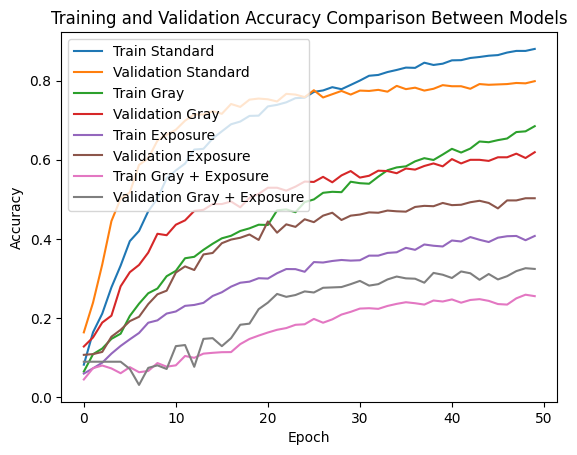

In [18]:
# Plot accuracy for the models with convolutional layers.
plt.plot(history_v1_standard.history['accuracy'], label='Train Standard')
plt.plot(history_v1_standard.history['val_accuracy'], label='Validation Standard')

plt.plot(history_v1_gray.history['accuracy'], label='Train Gray')
plt.plot(history_v1_gray.history['val_accuracy'], label='Validation Gray')

plt.plot(history_v1_exposure.history['accuracy'], label='Train Exposure')
plt.plot(history_v1_exposure.history['val_accuracy'], label='Validation Exposure')

plt.plot(history_v1_exposure_gray.history['accuracy'], label='Train Gray + Exposure')
plt.plot(history_v1_exposure_gray.history['val_accuracy'], label='Validation Gray + Exposure')

plt.title('Training and Validation Accuracy Comparison Between Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can observe the best performances for the standard images, it seems that using other transformations just reduce the accuracy... The simple's the best like we say. The standard model achieve the best performance but the gray scale model is not too bad as well. I suppose all the models are good but it seems the gray one and the standard one are the best. The exposure + gray scale model is just catastrophic. I We will continue to use all of these 3 models even if I don't think the exposure is relevant... It seems logical to say that the more the pictures are detailed, the easiest the model find the good answer.  
I am going to submit the performance of the standard and gray scale model. For that, I must train it on all the train data, so I will group my two lists and then save the content into a CSV file to submit my work on Kaggle.

In [19]:
# Add all train dataset.
x_train_total_standard = np.concatenate((x_train_standard, x_test_standard), axis=0)
y_train_total_standard = np.concatenate((y_train_standard, y_test_standard), axis=0)

x_train_total_gray = np.concatenate((x_train_gray, x_test_gray), axis=0)
y_train_total_gray = np.concatenate((y_train_gray, y_test_gray), axis=0)

print(x_train_total_standard.shape)
print(y_train_total_standard.shape)

print(x_train_total_gray.shape)
print(y_train_total_gray.shape)

(5458, 64, 64, 3)
(5458,)
(5458, 64, 64, 1)
(5458,)


Now let's train again our models with all data and make them predict results.

In [20]:
# Standard.
model_cnn_1_standard_total = get_model_cnn_v1(input_shape=(64, 64, 3))
samples_weight = compute_sample_weight("balanced", y_train_total_standard)
model_cnn_1_standard_total.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v1_standard = model_cnn_1_standard_total.fit(
    x=x_train_total_standard,
    y=y_train_total_standard,
    batch_size=512,
    epochs=50,
    sample_weight=samples_weight
)

# Gray scale.
model_cnn_1_gray_total = get_model_cnn_v1(input_shape=(64, 64, 1))
samples_weight = compute_sample_weight("balanced", y_train_total_gray)
model_cnn_1_gray_total.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v1_gray = model_cnn_1_gray_total.fit(
    x=x_train_total_gray,
    y=y_train_total_gray,
    batch_size=512,
    epochs=50,
    sample_weight=samples_weight
)

Epoch 1/50
11/11 [==============================] - 5s 220ms/step - loss: 2.8018 - accuracy: 0.1217
Epoch 2/50
11/11 [==============================] - 2s 188ms/step - loss: 2.4827 - accuracy: 0.2325
Epoch 3/50
11/11 [==============================] - 4s 290ms/step - loss: 2.1877 - accuracy: 0.3324
Epoch 4/50
11/11 [==============================] - 2s 164ms/step - loss: 1.9540 - accuracy: 0.3941
Epoch 5/50
11/11 [==============================] - 2s 146ms/step - loss: 1.7656 - accuracy: 0.4518
Epoch 6/50
11/11 [==============================] - 2s 149ms/step - loss: 1.6436 - accuracy: 0.4892
Epoch 7/50
11/11 [==============================] - 2s 146ms/step - loss: 1.5122 - accuracy: 0.5207
Epoch 8/50
11/11 [==============================] - 2s 145ms/step - loss: 1.3801 - accuracy: 0.5775
Epoch 9/50
11/11 [==============================] - 2s 147ms/step - loss: 1.2750 - accuracy: 0.5986
Epoch 10/50
11/11 [==============================] - 2s 142ms/step - loss: 1.2163 - accuracy: 0.6121

Let's save ou results now.

In [21]:
os.makedirs('working/predictions', exist_ok=True)
y_prediction_standard = model_cnn_1_standard_total.predict(x_final_standard)
y_prediction_standard = np.argmax(y_prediction_standard, axis=1)
result = pd.DataFrame({'path': df_test.path, 'classId': y_prediction_standard})
result.to_csv('working/predictions/submission_model_1_standard.csv', index=False)

19/19 [==============================] - 13s 9ms/step


Results : an accuracy of 0.80, not too bad I suppose but it can stille be improved. To do that, we are going to do the same process but with another model. We will dropout layers to try to increase the accuracy.

## Try with another model

In [22]:
def get_model_cnn_v2(input_shape=(64, 64, 1)):
    """
    Creates a Sequential model for classifying the simpsons using pooling and dropout layers.

    Parameters:
    - input_shape (tuple): The shape of input images (default is (64, 64, 1)).
    Returns:
    - model (Sequential): The compiled Keras Sequential model.
    """
    model = Sequential()

    # Convolutional layers with pooling.
    model.add(Input(shape=input_shape))
    if len(input_shape) == 3:
        model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

    # Flatten layer.
    model.add(Flatten())

    # Dense layers with Dropout.
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer.
    num_classes = 18  # Number of classes (digits 0-9).
    model.add(Dense(num_classes, activation='softmax'))

    return model

Repeat the same process for 3 models (not exposure + gray, because it is very bad).

In [23]:
save_callback_2 = keras.callbacks.ModelCheckpoint(filepath="models/model_v2", verbose=0, save_best_only=True)

model_cnn_2_standard = get_model_cnn_v2(input_shape=(64, 64, 3)) # Because we use a RGB image we precise the 3 here.

Let's check that we are < to 1M parameters.

In [24]:
model_cnn_1_standard.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

                                                                 
Total params: 407650 (1.56 MB)
Trainable params: 407650 (1.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's train our models.

In [25]:
samples_weight = compute_sample_weight("balanced", y_train_standard)
tensorboard_callback_2 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v2_standard", histogram_freq=1)
model_cnn_2_standard.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on 50 epochs.
history_v2_standard = model_cnn_2_standard.fit(
    x=x_train_standard,
    y=y_train_standard,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_2, tensorboard_callback_2],
    validation_data=(x_test_standard, y_test_standard),
    sample_weight=samples_weight
)

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.3375 - accuracy: 0.1129INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 44s 5s/step - loss: 3.3375 - accuracy: 0.1129 - val_loss: 2.7675 - val_accuracy: 0.1291
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.6325 - accuracy: 0.2304INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 863ms/step - loss: 2.6325 - accuracy: 0.2304 - val_loss: 2.6904 - val_accuracy: 0.2353
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.3178 - accuracy: 0.3007INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 832ms/step - loss: 2.3178 - accuracy: 0.3007 - val_loss: 2.6353 - val_accuracy: 0.2811
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 2.1328 - accuracy: 0.3447INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 9s 1s/step - loss: 2.1328 - accuracy: 0.3447 - val_loss: 2.6245 - val_accuracy: 0.2454
Epoch 5/50
9/9 [==============================] - ETA: 0s - loss: 2.0073 - accuracy: 0.3798INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 890ms/step - loss: 2.0073 - accuracy: 0.3798 - val_loss: 2.6221 - val_accuracy: 0.2271
Epoch 6/50
9/9 [==============================] - 4s 445ms/step - loss: 1.8769 - accuracy: 0.4123 - val_loss: 2.6555 - val_accuracy: 0.1868
Epoch 7/50
9/9 [==============================] - 4s 496ms/step - loss: 1.8232 - accuracy: 0.4336 - val_loss: 2.6679 - val_accuracy: 0.1832
Epoch 8/50
9/9 [==============================] - 4s 442ms/step - loss: 1.7275 - accuracy: 0.4560 - val_loss: 2.6861 - val_accuracy: 0.1786
Epoch 9/50
9/9 [==============================] - 4s 411ms/step - loss: 1.6457 - accuracy: 0.4801 - val_loss: 2.6969 - val_accuracy: 0.1731
Epoch 10/50
9/9 [==============================] - 4s 467ms/step - loss: 1.6063 - accuracy: 0.4956 - val_loss: 2.7120 - val_accuracy: 0.1703
Epoch 11/50
9/9 [==============================] - 4s 425ms/step - loss: 1.5626 - accuracy: 0.5158 - val_loss: 2.7141 - val_accuracy: 0.1676
Epoch 12/50
9/9 [============

INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 971ms/step - loss: 1.2332 - accuracy: 0.6230 - val_loss: 2.5763 - val_accuracy: 0.2280
Epoch 19/50
9/9 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.6349INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 9s 1s/step - loss: 1.1933 - accuracy: 0.6349 - val_loss: 2.5688 - val_accuracy: 0.2372
Epoch 20/50
9/9 [==============================] - 4s 468ms/step - loss: 1.1749 - accuracy: 0.6335 - val_loss: 2.6120 - val_accuracy: 0.2381
Epoch 21/50
9/9 [==============================] - 5s 552ms/step - loss: 1.1402 - accuracy: 0.6393 - val_loss: 2.5890 - val_accuracy: 0.2601
Epoch 22/50
9/9 [==============================] - ETA: 0s - loss: 1.0882 - accuracy: 0.6693INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 9s 1s/step - loss: 1.0882 - accuracy: 0.6693 - val_loss: 2.5160 - val_accuracy: 0.2756
Epoch 23/50
9/9 [==============================] - ETA: 0s - loss: 1.1036 - accuracy: 0.6633INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 1s/step - loss: 1.1036 - accuracy: 0.6633 - val_loss: 2.4793 - val_accuracy: 0.2921
Epoch 24/50
9/9 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.6741INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 814ms/step - loss: 1.0335 - accuracy: 0.6741 - val_loss: 2.3762 - val_accuracy: 0.3086
Epoch 25/50
9/9 [==============================] - ETA: 0s - loss: 1.0230 - accuracy: 0.6741INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 879ms/step - loss: 1.0230 - accuracy: 0.6741 - val_loss: 2.3352 - val_accuracy: 0.3315
Epoch 26/50
9/9 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.6885INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 9s 1s/step - loss: 0.9964 - accuracy: 0.6885 - val_loss: 2.3081 - val_accuracy: 0.3462
Epoch 27/50
9/9 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.6915INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 818ms/step - loss: 0.9827 - accuracy: 0.6915 - val_loss: 2.2886 - val_accuracy: 0.3462
Epoch 28/50
9/9 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.7032INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 971ms/step - loss: 0.9342 - accuracy: 0.7032 - val_loss: 2.1491 - val_accuracy: 0.3645
Epoch 29/50
9/9 [==============================] - ETA: 0s - loss: 0.9131 - accuracy: 0.7169INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 961ms/step - loss: 0.9131 - accuracy: 0.7169 - val_loss: 2.0443 - val_accuracy: 0.3855
Epoch 30/50
9/9 [==============================] - ETA: 0s - loss: 0.9102 - accuracy: 0.7029INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 1s/step - loss: 0.9102 - accuracy: 0.7029 - val_loss: 1.9863 - val_accuracy: 0.4066
Epoch 31/50
9/9 [==============================] - 3s 377ms/step - loss: 0.8812 - accuracy: 0.7192 - val_loss: 2.0534 - val_accuracy: 0.4002
Epoch 32/50
9/9 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.7187INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 791ms/step - loss: 0.8447 - accuracy: 0.7187 - val_loss: 1.9845 - val_accuracy: 0.4121
Epoch 33/50
9/9 [==============================] - ETA: 0s - loss: 0.8418 - accuracy: 0.7247INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 837ms/step - loss: 0.8418 - accuracy: 0.7247 - val_loss: 1.8501 - val_accuracy: 0.4524
Epoch 34/50
9/9 [==============================] - 4s 465ms/step - loss: 0.8188 - accuracy: 0.7350 - val_loss: 1.8968 - val_accuracy: 0.4350
Epoch 35/50
9/9 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.7510INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 905ms/step - loss: 0.7761 - accuracy: 0.7510 - val_loss: 1.6729 - val_accuracy: 0.5128
Epoch 36/50
9/9 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.7437INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 890ms/step - loss: 0.7816 - accuracy: 0.7437 - val_loss: 1.6502 - val_accuracy: 0.5174
Epoch 37/50
9/9 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.7561INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 811ms/step - loss: 0.7712 - accuracy: 0.7561 - val_loss: 1.5586 - val_accuracy: 0.5522
Epoch 38/50
9/9 [==============================] - 4s 412ms/step - loss: 0.7297 - accuracy: 0.7590 - val_loss: 1.5930 - val_accuracy: 0.5430
Epoch 39/50
9/9 [==============================] - 3s 383ms/step - loss: 0.7215 - accuracy: 0.7659 - val_loss: 1.5736 - val_accuracy: 0.5540
Epoch 40/50
9/9 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.7737INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 833ms/step - loss: 0.6967 - accuracy: 0.7737 - val_loss: 1.5336 - val_accuracy: 0.5641
Epoch 41/50
9/9 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.7794INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 8s 902ms/step - loss: 0.6960 - accuracy: 0.7794 - val_loss: 1.4816 - val_accuracy: 0.5769
Epoch 42/50
9/9 [==============================] - 5s 538ms/step - loss: 0.6513 - accuracy: 0.7858 - val_loss: 1.5572 - val_accuracy: 0.5668
Epoch 43/50
9/9 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.7783INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 856ms/step - loss: 0.6648 - accuracy: 0.7783 - val_loss: 1.3573 - val_accuracy: 0.6145
Epoch 44/50
9/9 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.7797INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 838ms/step - loss: 0.6513 - accuracy: 0.7797 - val_loss: 1.3475 - val_accuracy: 0.6154
Epoch 45/50
9/9 [==============================] - ETA: 0s - loss: 0.6382 - accuracy: 0.7854INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 6s 771ms/step - loss: 0.6382 - accuracy: 0.7854 - val_loss: 1.2984 - val_accuracy: 0.6346
Epoch 46/50
9/9 [==============================] - 4s 450ms/step - loss: 0.6445 - accuracy: 0.7847 - val_loss: 1.3185 - val_accuracy: 0.6291
Epoch 47/50
9/9 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.7980INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 791ms/step - loss: 0.6175 - accuracy: 0.7980 - val_loss: 1.1923 - val_accuracy: 0.6621
Epoch 48/50
9/9 [==============================] - 5s 557ms/step - loss: 0.5883 - accuracy: 0.8085 - val_loss: 1.3083 - val_accuracy: 0.6410
Epoch 49/50
9/9 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.8062INFO:tensorflow:Assets written to: models\model_v2\assets


INFO:tensorflow:Assets written to: models\model_v2\assets


9/9 [==============================] - 7s 801ms/step - loss: 0.5827 - accuracy: 0.8062 - val_loss: 1.1758 - val_accuracy: 0.6804
Epoch 50/50
9/9 [==============================] - 4s 466ms/step - loss: 0.5778 - accuracy: 0.8108 - val_loss: 1.1832 - val_accuracy: 0.6886


Let's now renew the operation with each of the previous image types.

In [26]:
# Gray scale.
model_cnn_2_gray = get_model_cnn_v2(input_shape=(64, 64, 1))
tensorboard_callback_2 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v2_gray", histogram_freq=1)
samples_weight = compute_sample_weight("balanced", y_train_gray)
model_cnn_2_gray.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v2_gray = model_cnn_2_gray.fit(
    x=x_train_gray,
    y=y_train_gray,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_2, tensorboard_callback_2],
    validation_data=(x_test_gray, y_test_gray),
    sample_weight=samples_weight
)

Epoch 1/50
9/9 [==============================] - 9s 549ms/step - loss: 3.6248 - accuracy: 0.0875 - val_loss: 2.8824 - val_accuracy: 0.1227
Epoch 2/50
9/9 [==============================] - 4s 408ms/step - loss: 3.1122 - accuracy: 0.1390 - val_loss: 2.8917 - val_accuracy: 0.0943
Epoch 3/50
9/9 [==============================] - 3s 365ms/step - loss: 2.8375 - accuracy: 0.1713 - val_loss: 2.8976 - val_accuracy: 0.0751
Epoch 4/50
9/9 [==============================] - 4s 500ms/step - loss: 2.6484 - accuracy: 0.2050 - val_loss: 2.9100 - val_accuracy: 0.0394
Epoch 5/50
9/9 [==============================] - 3s 361ms/step - loss: 2.5655 - accuracy: 0.2238 - val_loss: 2.9216 - val_accuracy: 0.0330
Epoch 6/50
9/9 [==============================] - 3s 382ms/step - loss: 2.4250 - accuracy: 0.2545 - val_loss: 2.9329 - val_accuracy: 0.0293
Epoch 7/50
9/9 [==============================] - 3s 363ms/step - loss: 2.3121 - accuracy: 0.2909 - val_loss: 2.9544 - val_accuracy: 0.0339
Epoch 8/50
9/9 [====

In [27]:
# Exposure.
model_cnn_2_exposure = get_model_cnn_v2(input_shape=(64, 64, 3))
tensorboard_callback_2 = keras.callbacks.TensorBoard(log_dir="logs/cnn_v2_exposure", histogram_freq=1)
samples_weight = compute_sample_weight("balanced", y_train_exposure)
model_cnn_2_exposure.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v2_exposure = model_cnn_2_exposure.fit(
    x=x_train_exposure,
    y=y_train_exposure,
    batch_size=512,
    epochs=50,	
    callbacks=[save_callback_2, tensorboard_callback_2],
    validation_data=(x_test_exposure, y_test_exposure),
    sample_weight=samples_weight
)

Epoch 1/50
9/9 [==============================] - 22s 2s/step - loss: 3.3937 - accuracy: 0.1145 - val_loss: 2.8896 - val_accuracy: 0.0266
Epoch 2/50
9/9 [==============================] - 4s 452ms/step - loss: 2.8360 - accuracy: 0.1869 - val_loss: 2.9023 - val_accuracy: 0.0852
Epoch 3/50
9/9 [==============================] - 4s 496ms/step - loss: 2.5603 - accuracy: 0.2430 - val_loss: 2.9320 - val_accuracy: 0.0852
Epoch 4/50
9/9 [==============================] - 5s 566ms/step - loss: 2.3202 - accuracy: 0.2996 - val_loss: 2.9714 - val_accuracy: 0.0852
Epoch 5/50
9/9 [==============================] - 5s 550ms/step - loss: 2.1416 - accuracy: 0.3541 - val_loss: 3.0033 - val_accuracy: 0.0201
Epoch 6/50
9/9 [==============================] - 8s 917ms/step - loss: 2.0256 - accuracy: 0.3704 - val_loss: 3.0397 - val_accuracy: 0.0348
Epoch 7/50
9/9 [==============================] - 6s 767ms/step - loss: 1.9040 - accuracy: 0.4180 - val_loss: 3.0748 - val_accuracy: 0.0348
Epoch 8/50
9/9 [======

Let's see the differences (and check tensorboard).

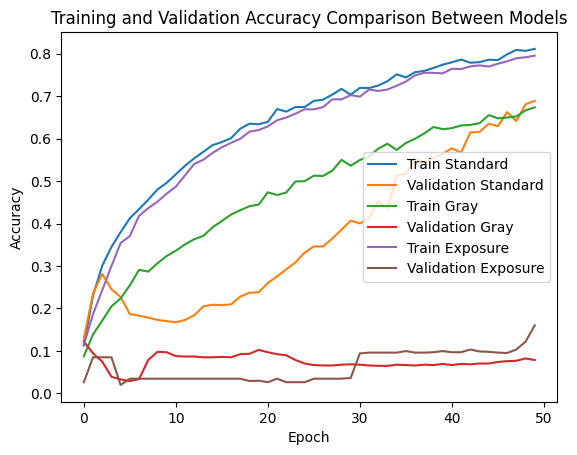

In [28]:
# Plot accuracy for the models with convolutional layers.
plt.plot(history_v2_standard.history['accuracy'], label='Train Standard')
plt.plot(history_v2_standard.history['val_accuracy'], label='Validation Standard')

plt.plot(history_v2_gray.history['accuracy'], label='Train Gray')
plt.plot(history_v2_gray.history['val_accuracy'], label='Validation Gray')

plt.plot(history_v2_exposure.history['accuracy'], label='Train Exposure')
plt.plot(history_v2_exposure.history['val_accuracy'], label='Validation Exposure')

plt.title('Training and Validation Accuracy Comparison Between Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems that the results show less accuracy from this model compared to the previous one, so I am going to even save the results of the standard model and submit them (beaucause it is the only model that can generalize if we compare to the the other 2).

In [30]:
# Standard.
model_cnn_2_standard_total = get_model_cnn_v2(input_shape=(64, 64, 3))
samples_weight = compute_sample_weight("balanced", y_train_total_standard)
model_cnn_2_standard_total.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_v2_standard = model_cnn_2_standard_total.fit(
    x=x_train_total_standard,
    y=y_train_total_standard,
    batch_size=512,
    epochs=50,
    sample_weight=samples_weight
)

Epoch 1/50
11/11 [==============================] - 20s 466ms/step - loss: 3.4203 - accuracy: 0.0934
Epoch 2/50
11/11 [==============================] - 4s 340ms/step - loss: 2.7322 - accuracy: 0.1854
Epoch 3/50
11/11 [==============================] - 3s 305ms/step - loss: 2.3960 - accuracy: 0.2523
Epoch 4/50
11/11 [==============================] - 3s 306ms/step - loss: 2.1976 - accuracy: 0.3049
Epoch 5/50
11/11 [==============================] - 3s 290ms/step - loss: 2.0631 - accuracy: 0.3340
Epoch 6/50
11/11 [==============================] - 3s 295ms/step - loss: 1.9345 - accuracy: 0.3719
Epoch 7/50
11/11 [==============================] - 3s 296ms/step - loss: 1.8451 - accuracy: 0.4049
Epoch 8/50
11/11 [==============================] - 3s 301ms/step - loss: 1.7373 - accuracy: 0.4359
Epoch 9/50
11/11 [==============================] - 3s 294ms/step - loss: 1.6581 - accuracy: 0.4808
Epoch 10/50
11/11 [==============================] - 3s 296ms/step - loss: 1.5957 - accuracy: 0.495

In [31]:
os.makedirs('working/predictions', exist_ok=True)
y_prediction_standard = model_cnn_2_standard_total.predict(x_final_standard)
y_prediction_standard = np.argmax(y_prediction_standard, axis=1)
result = pd.DataFrame({'path': df_test.path, 'classId': y_prediction_standard})
result.to_csv('working/predictions/submission_model_2_standard.csv', index=False)

19/19 [==============================] - 1s 18ms/step


In conlusion, the best accuracy I have reach is 0.8. I believe this score can be improved with more parameters, other model configurations, etc.